<a href="https://colab.research.google.com/github/myprogrammerpersonality/BlackBoxOptimizer/blob/master/BBO_v2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> version 2: </h1>
+ Alternative for each metabolite<br>           
+ RandomSearchCV each round<br>
+ Suggestion for low high stock conc<br>
+ Manual List Entering<br>
+ Visu Part at End

## User Inputs

Main notebook that includes data processing and bayesian optimization function

In [35]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/functions_final.py
from functions_final import *

--2020-08-26 22:16:00--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/functions_final.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20233 (20K) [text/plain]
Saving to: ‘functions_final.py.1’

functions_final.py. 100%[===================>]  19.76K  --.-KB/s    in 0.008s  

2020-08-26 22:16:00 (2.54 MB/s) - ‘functions_final.py.1’ saved [20233/20233]



In [2]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 13200 # (e.g. volume except lysate)
fixed_parts = {'Lysate':0.33, 'Saline':0.01} # 0.33 means 33% of total volume will be Lysate, 10% saline solution
days_total = 10 # how many days you want to continue # not mandatory parameter

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0,
               8: 0.5, 9: 0.5, 9: 0.5, 10: 0.5}
days_range = [m for i in range(days_total)]

In [3]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# format for one alternative : (min, max, stock)
# format for more than one alternatives : (min, max, stock, (alternative 1, alternative 2, alternative 3))
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'TF':(0.1, 100.0, 1000.0, ('A1', 'B2', 'C3')), # mM
 'K-Glutamate':(30, 150, 3000.0),
 'DNA':(20, 20, 1000)} # nM

concentrations_values = {
 'TF':([10, 20, 30, 50],1000.0, ('A1', 'B2', 'C3')),
 'K-Glutamate':([30, 100, 150, 200, 300, 350], 3000.0),
 'DNA':([20.0],1000.0)
}

automatic = True

if not automatic:
    concentrations_limits = concentrations_values
    random_combination_generator = random_combination_generator_conc_value

In [13]:
# Check Possible Concentrations
data_lists = {}
num = 0 
for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if automatic: print('Your Min, Max :', "({}, {})".format(value[0], value[1]))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter,
                                 verbose=0, automatic=automatic)
    print(concs)
    data_lists[num] = vols
    num += 1
    print()

percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
if pool_size > 10000000: pool_size = 10000000 
print(percent, '% of all possible combination are executable!')

Possible Conc For : TF
Your Min, Max : (0.1, 100.0)
[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0]

Possible Conc For : K-Glutamate
Your Min, Max : (30, 150)
[30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0, 150.0]

Possible Conc For : DNA
Your Min, Max : (20, 20)
[20.0]

100.0 % of all possible combination are executable!


In [5]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be in possible conc that calculated previosly ***

specials = {
"reference" : {'TF':[1.56], 'TF_A1':[0], 'TF_B2':[0], 'TF_C3':[1], 'K-Glutamate':[90.0], 'DNA':[20.0]},
            
"control_neg" : {'TF':[1.56], 'TF_A1':[0], 'TF_B2':[0], 'TF_C3':[1], 'K-Glutamate':[90.0], 'DNA':[0.0]}
}

## Day 1

In [6]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,TF,TF_A1,TF_B2,TF_C3,K-Glutamate,DNA
0,80.00,1.0,0.0,0.0,150.0,20.0
1,80.00,0.0,1.0,0.0,75.0,20.0
2,50.00,0.0,0.0,1.0,30.0,20.0
3,70.00,1.0,0.0,0.0,45.0,20.0
4,70.00,0.0,1.0,0.0,60.0,20.0
5,75.00,0.0,1.0,0.0,90.0,20.0
6,5.00,0.0,1.0,0.0,60.0,20.0
7,35.00,0.0,0.0,1.0,120.0,20.0
8,35.00,0.0,1.0,0.0,105.0,20.0
9,50.00,0.0,0.0,1.0,150.0,20.0


In [7]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [8]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts, automatic=automatic)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)

## Other Days

In [25]:
day = day_finder('Results') - 1
day

1

In [10]:
desired_cols = []
alternate_1 = 3
alternate_2 = 4
if not automatic:
    alternate_1 = 2
    alternate_2 = 3
for key, value in concentrations_limits.items():
    if len(value) == alternate_1:
        desired_cols.append(key)
    elif len(value) == alternate_2:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value[alternate_1]]
        desired_cols += alternative_name

fixed_col_value = process_limits(concentrations_limits)
final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])


for num in range(day):
    data_m, label_m, _, _= result_preprocess(num + 1, desired_cols, days_range[num])
    
    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,TF,TF_A1,TF_B2,TF_C3,K-Glutamate,DNA
0,80.00,1,0,0,150,20
1,80.00,0,1,0,75,20
2,50.00,0,0,1,30,20
3,70.00,1,0,0,45,20
4,70.00,0,1,0,60,20
5,75.00,0,1,0,90,20
6,5.00,0,1,0,60,20
7,35.00,0,0,1,120,20
8,35.00,0,1,0,105,20
9,50.00,0,0,1,150,20


In [11]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...


In [12]:
t0 = time.time()

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                         desired_cols=desired_cols, fixed_col_value=fixed_col_value, final_order=final_order,
                                         exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                         day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  0.619718074798584


,TF,TF_A1,TF_B2,TF_C3,K-Glutamate,DNA
0,75.0,0.0,0.0,1.0,105.0,20
1,5.0,0.0,0.0,1.0,75.0,20
2,75.0,0.0,0.0,1.0,120.0,20
3,45.0,0.0,0.0,1.0,75.0,20
4,65.0,0.0,0.0,1.0,75.0,20
5,35.0,0.0,0.0,1.0,75.0,20
6,95.0,0.0,0.0,1.0,75.0,20
7,5.0,0.0,0.0,1.0,150.0,20
8,50.0,0.0,0.0,1.0,135.0,20
9,5.0,0.0,0.0,1.0,60.0,20


In [14]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [15]:
# check to dont make repeated combination
previous = [pd.read_csv('Day_{}/Concentrations_{}.csv'.format(i,i)).iloc[:m,:] for i in range(1, day+1)]

df_main = pd.concat(previous)

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

In [16]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Data From Day_1 to Now


In [55]:
display_std = True

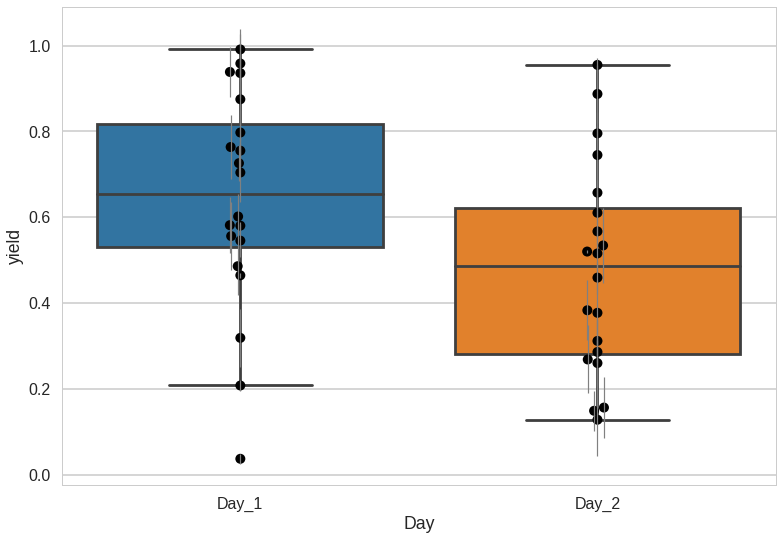

In [56]:
day = day_finder('Results')
Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(1,day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    Results_i['yield'] = pd.read_csv(f'Day_{i}/Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    try:
        Results_i['std'] = pd.read_csv(f'Day_{i}/Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
    except:
        Results_i['std'] = 0
    Results_i['Day'] = f'Day_{i}'
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    errors = Results_m['std']
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ',color="grey", zorder=3, linewidth=1.2)
ax